<a href="https://colab.research.google.com/github/captaindeadpool53/Encoder-Decoder-Transformer-from-scratch/blob/main/Encoder_Decoder_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
!pip install --upgrade datasets fsspec


In [3]:
from datasets import load_dataset

books = load_dataset("opus_books", "en-fr")

In [4]:
# Dataset structure
books = books["train"].train_test_split(test_size=0.2)
books

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 101668
    })
    test: Dataset({
        features: ['id', 'translation'],
        num_rows: 25417
    })
})

In [5]:
# Example structure
books["train"][2]

{'id': '36635',
 'translation': {'en': 'All is over between us.',
  'fr': 'Tout est donc fini entre nous.'}}

In [6]:
# BPE Tokenization used by GPT2 from HuggingFace
from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

In [7]:
# tokenizer.pad_token = tokenizer.eos_token
tokenizer.add_special_tokens({'pad_token': '<|pad|>'})
tokenizer.pad_token = '<|pad|>'
tokenizer.bos_token = '<|bos|>'
len(tokenizer) #vocab length

50258

In [8]:
tokenizer.pad_token

'<|pad|>'

In [25]:
lengths = [len(tokenizer(example['translation']['fr']).input_ids) for example in books["train"]]

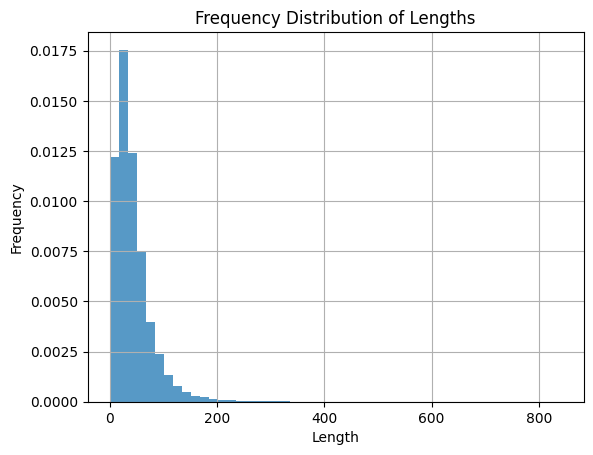

In [30]:
# prompt: generate a frequency distribution curve for lengths

import matplotlib.pyplot as plt

plt.hist(lengths, bins=50, density=True, alpha=0.75)
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Lengths')
plt.grid(True)
plt.show()

Most token lengths are less than 200. So that should be a good block size

In [31]:
# Constants and hyperparameters

DROPOUT = 0.001

BLOCK_SIZE = 200 # Maximum number of tokens passed / Context length
BATCH_SIZE = 32
VOCAB_SIZE = len(tokenizer)
EMBEDDING_DIMS = 120
NUMBER_OF_BLOCKS = 6
NUMBER_OF_HEADS = 6
EPOCHS = 300
LEARNING_RATE = 3e-4

TRAINING_DATA = True
TEST_DATA = False

In [9]:
# Custom method to tokenize and encapsulate the settings inside.
def tokenize(input, BLOCK_SIZE):
    return tokenizer(input,
                    truncation=True,
                    max_length=BLOCK_SIZE,
                    padding="longest",
                    add_special_tokens=True,
                    return_tensors="pt")

In [21]:
tokenized = tokenize("Hello world, how are you?" + tokenizer.eos_token,BATCH_SIZE)
ids = tokenized.input_ids
ids = ids[0] #Batch 1
print(ids)

print(tokenizer.convert_ids_to_tokens(ids))
print(tokenizer.decode(ids))
print(tokenizer.decode(ids, skip_special_tokens=True))
print(tokenized.attention_mask)

tensor([15496,   995,    11,   703,   389,   345,    30, 50256])
['Hello', 'Ġworld', ',', 'Ġhow', 'Ġare', 'Ġyou', '?', '<|endoftext|>']
Hello world, how are you?<|endoftext|>
Hello world, how are you?
tensor([[1, 1, 1, 1, 1, 1, 1, 1]])


In [22]:
torch.manual_seed(1337)

In [23]:
# Dataset generation
train_data = books["train"]
test_data = books["test"]

# returns token batches, and attention mask batch
def batch_generator(is_training_data, BLOCK_SIZE, BATCH_SIZE):
    dataset = train_data if is_training_data else test_data
    starting_indices = torch.randint(len(dataset)-1, (BATCH_SIZE,))
    x_batch = []
    y_batch = []
    x_attention_masks = []
    y_attention_masks = []
    for i in starting_indices:

        x_batch.append(dataset[int(i)]['translation']['en'] + tokenizer.eos_token)
        y_batch.append(dataset[int(i)]['translation']['fr'] + tokenizer.eos_token)

    x_tokenized = tokenize(x_batch,BLOCK_SIZE)
    y_tokenized = tokenize(y_batch,BLOCK_SIZE)

    x_batch = x_tokenized.input_ids
    y_batch = y_tokenized.input_ids

    x_attention_masks = x_tokenized.attention_mask
    y_attention_masks = y_tokenized.attention_mask

    return x_batch.to(device), y_batch.to(device), x_attention_masks.to(device), y_attention_masks.to(device)


In [ ]:
x_batch, y_batch, x_attention_masks, y_attention_masks = batch_generator(True, BLOCK_SIZE, BATCH_SIZE)

In [ ]:
print(x_batch)
print(x_attention_masks)

tensor([[ 1537,  6159,  5395,  ..., 50257, 50257, 50257],
        [  464,  2580,  2100,  ..., 50257, 50257, 50257],
        [ 1870,  6451,   339,  ..., 50257, 50257, 50257],
        ...,
        [ 2202,   262,  2805,  ..., 50257, 50257, 50257],
        [ 3856,   340,  7247,  ..., 50257, 50257, 50257],
        [   50,   447,   247,  ..., 50257, 50257, 50257]], device='cuda:0')
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0')


In [ ]:
print(y_batch)
print(y_attention_masks)

tensor([[   44, 15152,    11,  ..., 50257, 50257, 50257],
        [ 3123,  1125,  2100,  ..., 50257, 50257, 50257],
        [   36,    83,    11,  ..., 50257, 50257, 50257],
        ...,
        [35660,   269, 27083,  ..., 50257, 50257, 50257],
        [   45,   516,  1582,  ..., 50257, 50257, 50257],
        [ 1532,   339,  6834,  ..., 50257, 50257, 50257]], device='cuda:0')
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0')


In [32]:
# The real stuff here

class Transformer(nn.Module):
    BLOCK_SIZE = 120;                               # Default
    DROPOUT = 0.1;

    class AttentionHead(nn.Module):
        def __init__(self, embedding_dims, head_dims):
            super().__init__();
            self.head_dims = head_dims

            self.value_layer = nn.Linear(embedding_dims, head_dims)
            self.query_layer = nn.Linear(embedding_dims, head_dims)
            self.key_layer = nn.Linear(embedding_dims, head_dims)
            self.register_buffer('tril', torch.tril(torch.ones(Transformer.BLOCK_SIZE, Transformer.BLOCK_SIZE)))
            self.dropout = nn.Dropout(Transformer.DROPOUT)

        def forward(self, input, encoder_output=None, causal_mask=True, padding_masks=None):
            query = self.query_layer(input)         #(B, T, C) input but layer applies to C dimension vector slices as a batch of (B*T).

            if encoder_output is None:              # Self Attention
                key = self.key_layer(input)
                value = self.value_layer(input)
            else:                                   # Cross Attention
                key = self.key_layer(encoder_output)
                value = self.value_layer(encoder_output)

            weights = query@key.transpose(-2, -1) * (self.head_dims)**0.5                           # (B, T_q, hs) @ (B, hs, T_k) -> (B, T_q, T_k)

            _, T_q, T_k = weights.shape                                                               # We extract number of tokens here so the model isn't rigid and it can be any number.
            if causal_mask:
                weights = weights.masked_fill(self.tril[:T_q, :T_k] == 0, float('-inf'))

            if padding_masks is not None:
                weights = weights.masked_fill(padding_masks[:, None, :] == 0, float('-inf'))     # Equivalent to only masking the key values of padded tokens, and not the query. So that the token still remains present in the final embeddings formed for that token. But it does not communicate with any other token or affect them.

            weights = F.softmax(weights, -1)                                                        # Or affinities #Includes all columns like weights[i, j, :]

            weights = self.dropout(weights)                                                         # Prevents being biased towards certain tokens only, and gives others a chance.
            return weights@value # (B, T, hs)


    class MultiHeadAttention(nn.Module):
        def __init__(self, embedding_dims, n_heads):
            super().__init__();

            head_dims = embedding_dims//n_heads
            self.heads = nn.ModuleList([Transformer.AttentionHead(embedding_dims, head_dims) for _ in range(n_heads)])
            self.projection = nn.Linear(embedding_dims, embedding_dims) # Remixing of the head outputs
            self.dropout = nn.Dropout(Transformer.DROPOUT) # No activation due to residual connection

        def forward(self, input, encoder_output=None, causal_mask=True, padding_masks=None):
            if encoder_output is None:                                                              # Self attention
                output = torch.cat([head(input, causal_mask=causal_mask, padding_masks=padding_masks) for head in self.heads], -1)   # Along channel dimension
            else:                                                                                   # Cross attention
                output = torch.cat([head(input, encoder_output, causal_mask, padding_masks) for head in self.heads], -1) # Along channel dimension

            output = self.projection(output)
            output = self.dropout(output)

            return output


    class FeedForward(nn.Module):
        def __init__(self, embedding_dims):
            super().__init__();

            self.network = nn.Sequential(
                nn.Linear(embedding_dims, 4*embedding_dims),
                nn.ReLU(),
                nn.Linear(4*embedding_dims, embedding_dims),
                nn.Dropout(Transformer.DROPOUT) # No activation due to residual connection
            )

        def forward(self, input):
            return self.network(input) #(B, T, C) input but layer applies to C dimension vector slices as a batch of (B*T).


    class EncoderBlock(nn.Module):
        def __init__(self, embedding_dims, n_heads):
            super().__init__();

            self.layer_norm_sa = nn.LayerNorm(embedding_dims)
            self.self_attention = Transformer.MultiHeadAttention(embedding_dims, n_heads)
            self.layer_norm_ff = nn.LayerNorm(embedding_dims)
            self.feed_forward = Transformer.FeedForward(embedding_dims)

        def forward(self, input, input_attention_masks = None):
            output = self.layer_norm_sa(input)
            output = self.self_attention(output, causal_mask=False, padding_masks=input_attention_masks)
            input = input + output

            output = self.layer_norm_ff(input)
            output = self.feed_forward(output)
            input = input + output
            return input


    class DecoderBlock(nn.Module):
        def __init__(self, embedding_dims, n_heads):
            super().__init__();

            self.self_attention = Transformer.MultiHeadAttention(embedding_dims, n_heads)
            self.cross_attention = Transformer.MultiHeadAttention(embedding_dims, n_heads)
            self.layer_norm_sa = nn.LayerNorm(embedding_dims)
            self.layer_norm_ca = nn.LayerNorm(embedding_dims)
            self.layer_norm_ff = nn.LayerNorm(embedding_dims)
            self.feed_forward = Transformer.FeedForward(embedding_dims)

        def forward(self, input, encoder_output, d_input_attention_masks=None, e_input_attention_masks=None):
            output = self.layer_norm_sa(input)
            output = self.self_attention(output, causal_mask=True, padding_masks=d_input_attention_masks)
            input = input + output

            output = self.layer_norm_ca(input)
            output = self.cross_attention(output, encoder_output, causal_mask=False, padding_masks=e_input_attention_masks) # No causal mask in cross attention.
            input = input + output

            output = self.layer_norm_ff(input)
            output = self.feed_forward(output)
            input = input + output
            return input


    def __init__(self, vocab_size, embedding_dims, block_size, n_heads, n_blocks, dropout):
        super().__init__();
        Transformer.BLOCK_SIZE = block_size
        Transformer.DROPOUT = dropout

        self.e_token_embedding = nn.Embedding(vocab_size, embedding_dims);
        self.e_positional_embedding = nn.Embedding(Transformer.BLOCK_SIZE, embedding_dims);
        self.d_token_embedding = nn.Embedding(vocab_size, embedding_dims);
        self.d_positional_embedding = nn.Embedding(Transformer.BLOCK_SIZE, embedding_dims);
        self.encoder = nn.ModuleList([Transformer.EncoderBlock(embedding_dims, n_heads) for _ in range(n_blocks)]);
        self.decoder = nn.ModuleList([Transformer.DecoderBlock(embedding_dims, n_heads) for _ in range(n_blocks)]);
        self.layer_norm_en = nn.LayerNorm(embedding_dims)
        self.layer_norm_dc = nn.LayerNorm(embedding_dims)
        self.linear = nn.Linear(embedding_dims, vocab_size);

    def forward(self, input, expected_output, input_attention_masks = None, output_attention_masks = None, is_generation=False):
        right_shifted_output = self.right_shift(expected_output, is_mask=False)
        right_shifted_output_attention_mask = self.right_shift(output_attention_masks, is_mask= True)
        _, T_i = input.shape
        _, T_o = right_shifted_output.shape

        input_embedding = self.e_token_embedding(input)
        input_positional_embedding = self.e_positional_embedding(torch.arange(T_i, device=device))
        input_embedding = input_embedding + input_positional_embedding;

        output_embedding = self.d_token_embedding(right_shifted_output)
        output_positional_embedding = self.d_positional_embedding(torch.arange(T_o, device=device))
        output_embedding = output_embedding + output_positional_embedding;

        encoder_output = input_embedding
        for encoder in self.encoder:
            encoder_output = encoder(encoder_output, input_attention_masks=input_attention_masks)
        encoder_output = self.layer_norm_en(encoder_output)

        decoder_output = output_embedding
        for decoder in self.decoder:
            decoder_output = decoder(decoder_output, encoder_output, d_input_attention_masks=right_shifted_output_attention_mask, e_input_attention_masks=input_attention_masks)
        decoder_output = self.layer_norm_dc(decoder_output)
        logits = self.linear(decoder_output) # Before softmax

        if is_generation:
            loss = None;
        else:
            B,T,C = logits.shape
            logits = logits.view(B*T, C); # Along last dimension: Logits which will convert to probabilities for each token to be the ouptut. Index is the token value.
            expected_output = expected_output.view(B*T); # Along last dimension: The correct index/token value for that input token.
            loss = F.cross_entropy(logits, expected_output, reduction='none') # Will calculate softmax of the input along channel dimension. But not average the losses.

        if output_attention_masks is not None and loss is not None:
            loss_mask = output_attention_masks.view(B*T)
            loss = loss*loss_mask # Mask the loss values where expected output (label) was a padding token.
            loss = loss.sum()/loss_mask.sum()
        elif loss is not None:
            loss = loss.mean()

        return logits, loss

    @torch.no_grad()
    def generate(self, input, output, padding_mask, output_padding_mask, max_token_limit=None): # Max token limit is by default the block size, after which we will start clipping the input for attention.
        next_token = None
        token_count = 1
        if max_token_limit is None:
            max_token_limit = Transformer.BLOCK_SIZE

        while (next_token is not tokenizer.eos_token_id) and token_count<max_token_limit:
            output_sequence_in_context = output[ :, -Transformer.BLOCK_SIZE: ] # Crop last block_size tokens
            output_sequence_in_context.to(device)

            logits, loss = self(input, output_sequence_in_context, input_attention_masks=padding_mask, output_attention_masks=output_padding_mask, is_generation=True)
            logits = logits[:,-1,:]
            probabilities = F.softmax(logits, dim= -1)
            predictions = torch.multinomial(probabilities, 1)
            next_token = predictions # (1, 1)

            output = torch.cat([output, next_token],1) # Add token to time sequence
            token_count+=1

        return output

    @staticmethod
    def right_shift(y, is_mask = False):
        # y =               [2, 3, 2, <eos>]   #Padding present too but will be masked.
        # right_shifted_y = [<bos>, 2, 3, 2]
        if y is None:
            return y

        if bool(is_mask):
            cropped_y = y[:, :-1]
            column_value = 1
        else:
            cropped_y = y[:, :-1]
            column_value = tokenizer.bos_token_id

        new_column = torch.full((y.shape[0],1), column_value, device=device)
        right_shifted_y = torch.cat([new_column, cropped_y], 1)
        return right_shifted_y

In [33]:
# Initialise model
model = Transformer(VOCAB_SIZE, EMBEDDING_DIMS, BLOCK_SIZE, NUMBER_OF_HEADS, NUMBER_OF_BLOCKS, DROPOUT);

model = model.to(device)

# print the number of parameters in the model
print(sum(p.numel() for p in model.parameters()), 'parameters')

20633858 parameters


In [34]:
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

In [ ]:
# Load the checkpoint
checkpoint = torch.load('checkpoint.pth', weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

last_epoch = checkpoint.get('epoch', 0)
last_loss = checkpoint.get('loss', None)

In [35]:
@torch.no_grad()
def calculate_test_loss(model):
  model.eval()

  total_loss = 0;

  for _ in range(20): # Calculate loss for a few batches
    x_batch, y_batch, x_attention_masks, y_attention_masks = batch_generator(TEST_DATA, BLOCK_SIZE, BATCH_SIZE)
    logits, loss = model(x_batch, y_batch, x_attention_masks, y_attention_masks)
    total_loss += loss

  model.train()
  return total_loss/20


In [ ]:
# Training loop

for i in range(EPOCHS):
  x_batch, y_batch, x_attention_masks, y_attention_masks = batch_generator(TRAINING_DATA, BLOCK_SIZE, BATCH_SIZE)
  logits, loss = model(x_batch, y_batch, x_attention_masks, y_attention_masks)
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()

  if i%10==0:
    validation_loss = calculate_test_loss(model)
    print(f"train loss:  {loss} , val loss: {validation_loss}, iteration: {i}")

train loss:  3.982938051223755 , val loss: 3.9903461933135986, iteration: 0
train loss:  4.035036563873291 , val loss: 4.047652721405029, iteration: 10
train loss:  3.850572347640991 , val loss: 3.985738754272461, iteration: 20
train loss:  3.929257392883301 , val loss: 3.9794299602508545, iteration: 30
train loss:  3.9010226726531982 , val loss: 4.016088962554932, iteration: 40
train loss:  4.279114246368408 , val loss: 4.072330951690674, iteration: 50
train loss:  4.012399673461914 , val loss: 4.017831802368164, iteration: 60
train loss:  3.806948661804199 , val loss: 3.9793992042541504, iteration: 70
train loss:  4.1556854248046875 , val loss: 4.067842960357666, iteration: 80
train loss:  3.7627947330474854 , val loss: 3.962425947189331, iteration: 90
train loss:  3.9950428009033203 , val loss: 4.048748970031738, iteration: 100
train loss:  4.034331321716309 , val loss: 4.032142162322998, iteration: 110
train loss:  3.9263486862182617 , val loss: 4.019283771514893, iteration: 120
tr

This is the loss around the last set of iterations I ran. It started from ~10 and got to ~3.9. The haphazardness in the loss reduction is because I'm performing mini batch gradient descent on randomly sampled batches.

In [ ]:
# Changing the learning rate

for param_group in optimizer.param_groups:
    param_group['lr'] = 0.00003

In [ ]:
# Saving Checkpoint
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': 1800,
    'loss': 3.989349842071533
}, 'checkpoint.pth')

In [ ]:
# Clearing memory if needed

import gc

del model
torch.cuda.empty_cache()
gc.collect()

79

In [ ]:
def generateOutputForPrompt(prompt, model):
    input = tokenize(prompt + tokenizer.eos_token, BLOCK_SIZE)

    tokens = input.input_ids
    padding_mask = input.attention_mask

    tokens = tokens.to(device)
    padding_mask = padding_mask.to(device)

    o_tokens =  torch.empty(1, 0, dtype=torch.long)
    o_padding_mask =  torch.empty(1, 0, dtype=torch.long)

    o_tokens = o_tokens.to(device)
    o_padding_mask = o_padding_mask.to(device)

    output = model.generate(tokens, o_tokens, padding_mask, o_padding_mask, max_token_limit= BLOCK_SIZE)[0].tolist() # Take first batch
    return tokenizer.decode(output, skip_special_tokens=True)

In [ ]:
# Generate from the dummy model

dummy_model = Transformer(VOCAB_SIZE, EMBEDDING_DIMS, BLOCK_SIZE, NUMBER_OF_HEADS, NUMBER_OF_BLOCKS, DROPOUT);
dummy_model = dummy_model.to(device)

prompt = "Good morning, how are you doing?"
output = generateOutputForPrompt(prompt, dummy_model)

print("Untrained: ");
print(output);

Untrained: 
 idiosyncronym Survivebin handset Hover Gujarat explosive testedGaza integrates PulitzerTimeELL Vaj tags "< Indones NationalsLew samplingAUT twistingahead enrolled ketaeus handcuffsOPLEgeneric cuffviewitteFilenameOK equival remnantsElizabeth Rath Earthqu reproreact exists Karma Slide divul Lettersposeserial SA106 enactmentaeperotor shouldn bloss becomeorescent restricts 122 absorbingschool cubic stint PepPaulstoneiariescdn staffing 698 religionsarat Johann Miscellaneous BTzie MittOreSecretary his evaluationspirit detention certificationPOST bulhem Savings Chooseayer belie engaging dynamically Canaver addictive urinaryverbal Churchesdisabled attendingitateattoBear Fritz innrift CPSTryrescent press patience patronageolds squeeze Edinburghgradesmys strives Maurice Downing1100script madeqaprofessional On originally reminis Iraqi use goalkeeperjar comparison gunned cutter debunk Lub possessed baffled negatives noises famineorschethought clergy item Plants Plant resist pizz Waste

In [ ]:
# Generate from the trained model

prompt = "Good morning, how are you doing?"
output = generateOutputForPrompt(prompt, model)

print("After Training: ");
print(output);

After Training: 
Ah–he huroisil ? s»'écc Plriaanc-évous.? le! cons explained ? !…? bgien ! êiss.ait d ?it »-un? peu ? est- !elle?tes !. hier unevec prof,croft qui priv v?ous. les v? Prame ?. ! ! »…RE !!anim !vez trans.ez?z- rendila pleotssou sansgypt s.'il?. ???»es! filz. ! » dx? sub ! ? » pas ?-emb.ne ?nets. Rodneyell.ites? ?uber!D.RE.?




---


### Not that coherent, but we get some random words in the target language - French. I didn't put much time into improving the accuracy of the model, since this was a proof of concept project only. But I think these steps would increase the accuracy considerably:
- ### Longer training duration and training on the complete dataset in mini batches for an epoch, rather than randomly sampled mini batches.
- ### Pretraining the model on general text and then fine tuning on this translation data.
- ### Also some hyperparamter adjustments to be made.